# Tutorial on PathTree Visualization

We will use the results from the mstis example. So make sure this has been run (not analyzed) before and the `mstis.nc` file exists.

The usual import

In [1]:
import openpathsampling as paths

Import visualization as `vis` for convenience

In [2]:
import openpathsampling.visualize as vis

And use output for SVG in IPython notebooks

In [3]:
from IPython.display import SVG

Load the storage into memory.

In [4]:
storage = paths.AnalysisStorage("mstis.nc")

Track down the list of samples that lead to the existance of the last sample in storage (called the heritage)

In [5]:
reload(vis)

<module 'openpathsampling.visualize' from '/Users/jan-hendrikprinz/Studium/git/openpathsampling/openpathsampling/visualize.pyc'>

Create a TreeBuilder object that will take care of the SVG generation for us.

In [6]:
pt = vis.PathTreeBuilder.from_ancestors(storage.samples.last)

Let's look at some possible options before we plot

##### `.samples` options

The `PathTreeBuilder` has a `SampleList` object stored in `.samples`. These has some options about how the contained samples should be analyzed for their correlation.

```
time_symmetric : bool
    If `True` snapshots and its reversed counterpart are treated as the 
    same configuration
```

In [7]:
pt.samples.time_symmetric = True

```
flip_time_direction : bool
    If `True` then the use of a reversal in time evolution of trajectories 
    (so far only Reversesal moves to that) will cause the plot to also 
    reverse its current "sense of time". If False time is always drawn from 
    left to right. While having the disadvantage of distorting the view of 
    time, this has the advantage that snapshots after a reversal will still 
    be align beneath and so the apparent correlation between paths after a 
    reversal is directly visible.
```

In [8]:
pt.samples.flip_time_direction = False

```
joined_blocks : bool
    If `True` then snapshot blocks and joined into a large block. This remove
    the possibility to see the optional CV value per snapshot but increases
    generation of the image a lot.
```

Set some options for the SVG output before rendering it.

### `.options`

Styling and other settings are set in `.options`

##### CSS

CSS are things that affect the css directly like shape, size and overall appearance.

`scale_x` and `scale_y` is the distance in pixels between two blocks. Since the figure can be scaled arbitrarily only the relative number matters. Still it is useful to pick a default size in the browser. 

`zoom` will be applied to the whole image and might be useful for saving and printing. 

In [9]:
pt.options.css['scale_x'] = 2
pt.options.css['scale_y'] = 24
pt.options.css['zoom'] = 1.0

`width` applies to the output scaling in a browser. Typical choices are `inherit` which will leave the actual number of pixels and result in the same block size independent of the number of snapshots per trajectory. `xxx%` which will scale the whole image to fit a certain percentage of the available space. `xxxpx` will scale the whole image to fit exactly into the given number of pixels. In general all css conform widths are supported.

In [10]:
pt.options.css['width'] = 'inherit'

`horizontal_gap` is a bool and if set to true it will make each snapshot be separated by a little gap. If turned off you will get continuous blocks.

In [11]:
pt.options.css['horizontal_gap'] = False

`mark_transparent` sets the reason when samples will be shown transparent. 

1. `rejected` (default): transparent, if the sample originated in a rejected step. Useful for analyzing steps
2. `auxiliary`: transparent, if the sample is not necessary to construct the last sample and 
3. `mover`: transparent, if the sub_move was rejected. This is different from 1. in that 1. only check acceptance of the root_mover

In [ ]:
pt.options.css['mark_transparent'] = 'rejected'

##### UI

UI are things that affect which content will be shown, such as additional legends, hints, virtual samples, etc.

`correlation`, `sample`, `ensemble`, `replica`, `bias`, `step` are parts of the legends that can be chosen. 

In [12]:
pt.options.ui['legends'] = [ 'correlation', 'sample', 'ensemble', 'step', 'bias', 'replica']

The last option sets whether to show the value of a collective variable

In [13]:
pt.options.ui['cv'] = True

##### Mover

The mover category contains information on how to plot certain mover types.

```py
pt.options.movers[mover_type]['name'] = '...'
pt.options.movers[mover_type]['suffix'] = '...'
pt.options.movers[mover_type]['overlap_label'] = '...'

pt.options.movers[mover_type]['label_position'] = 'left' or 'right'

pt.options.movers[mover_type]['overlap'] = '...'
pt.options.movers[mover_type]['new'] = '...'
pt.options.movers[mover_type]['reversed'] = '...'
pt.options.movers[mover_type]['full'] = '...'


pt.options.movers[mover_type]['cls'] = '...'
```

##### Direct attribute settings

`.op` will reference a function that is used to determined the text inside each snapshot. If `None` nothing will be displayed. A common choice if the `.idx` function of the used storage. This will use the index of the snapshot stored. If it is set to `None` it will be ignored. Note, that if you will join blocks then this will also be ignored since no blocks will be plotted.

In [14]:
#pt.op = storage.idx
pt.op = None

`.states` is a dictionary which will reference boolean CVs with a color. If the CV will return True for a snapshots a block of the given color is put below the snapshot. This way certain states can be marked and seen if trajectories are of the correct type.

In [15]:
pt.states = {
    'orange' : storage.volumes[0]
}

In [16]:
pt.states = {}

Finally tell the builder to render the SVG and put it out. This might take a few seconds if the plot is large.

Let's start fresh and set some options altogether.

In [17]:
reload(vis)

<module 'openpathsampling.visualize' from '/Users/jan-hendrikprinz/Studium/git/openpathsampling/openpathsampling/visualize.pyc'>

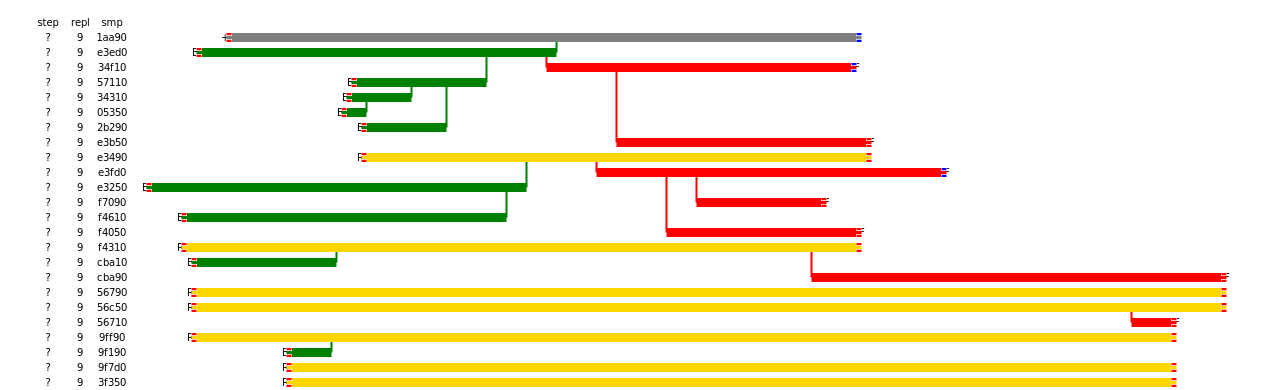

In [18]:
pt = vis.PathTreeBuilder.from_ancestors(storage.samples.last)
pt.states = {
    'red': storage.volumes['A'],
    'green': storage.volumes['B'],
    'blue': storage.volumes['C']
}
pt.options.ui['legends'] = ['sample', 'replica', 'step']
SVG(pt.svg())

We are often interested in the evolution of a replica during the simulation we can do that, too. 
Just generate a SampleList that contains the specific samples

In [19]:
history = vis.PathTreeBuilder.from_steps(
    steps=storage.steps[:],
    replica=1,
    accepted=True
)
history.use_storage_indices(storage)

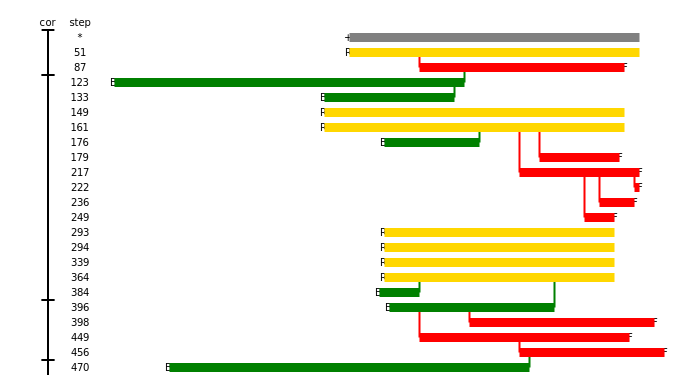

In [20]:
SVG(history.svg())

You can add more legends if you want. There is a list with names of legend parts.

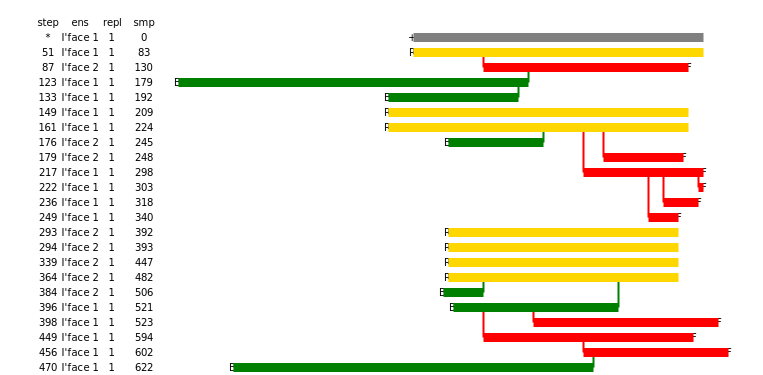

In [21]:
history.options.ui['legends'] = ['sample', 'replica', 'ensemble', 'step']
SVG(history.svg())

A PathTreeBuilder for steps can do even more. The `.samples` has an option to change the replica and switch between accepted and rejected.

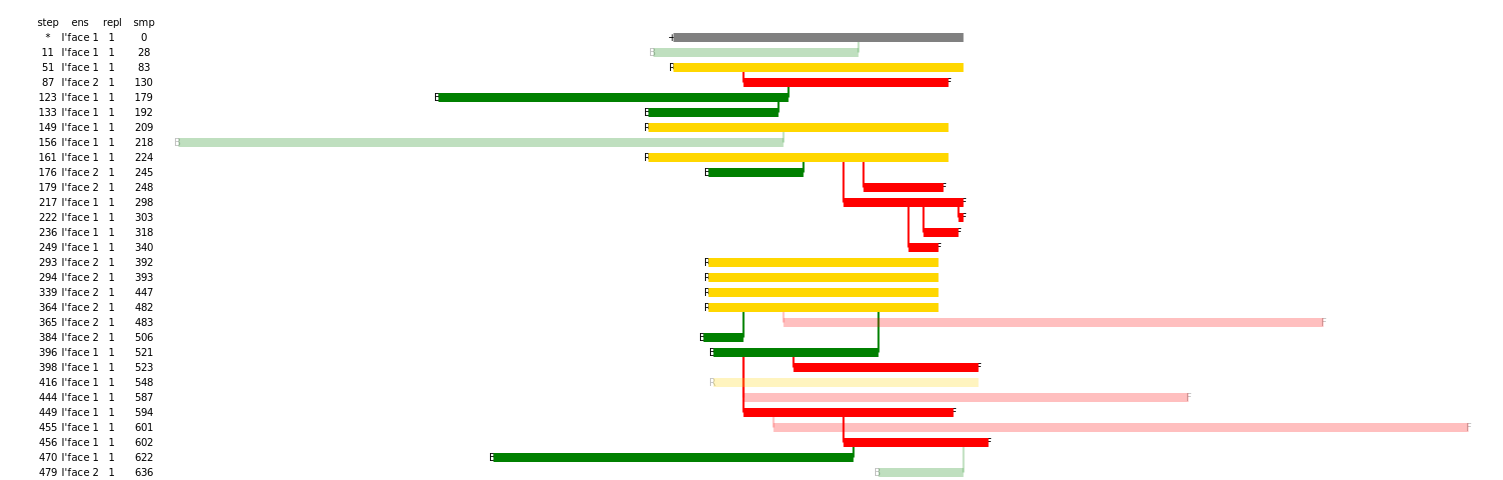

In [22]:
history.samples.accepted = False
history.replica = 3
SVG(history.svg())

Let's do something fancy and color each snapshot

In [23]:
cvA = storage.cvs['opA']
cvB = storage.cvs['opB']
cvC = storage.cvs['opC']
mxA = max(cvA(storage.snapshots.all()))
mxB = max(cvB(storage.snapshots.all()))
mxC = max(cvC(storage.snapshots.all()))

For this we need a color function that returns a valid SVG color for each snapshot

In [24]:
svg_colorfunction = lambda x: 'rgb(' + \
    str(int(255 * (1 - cvA(x) / mxA))) + ',' + \
    str(int(255 * (1 - cvB(x) / mxB))) + ',' + \
    str(int(255 * (1 - cvC(x) / mxC))) + ')'

Here we color according to the proximity to states `A` (red), `B` (green) and `C` (blue). You  see, that all paths that are not in the right ensemble are rejected!

In [25]:
# set all trajectory parts to single mode to see something
history.options.movers['default']['new'] = 'single'
history.options.movers['default']['reversed'] = 'single'
history.options.movers['default']['overlap'] = 'none'
history.options.movers['default']['full'] = 'single'

history.states = {
    'red': storage.volumes['A'],
    'green': storage.volumes['B'],
    'blue': storage.volumes['C']
}

history.coloring = svg_colorfunction

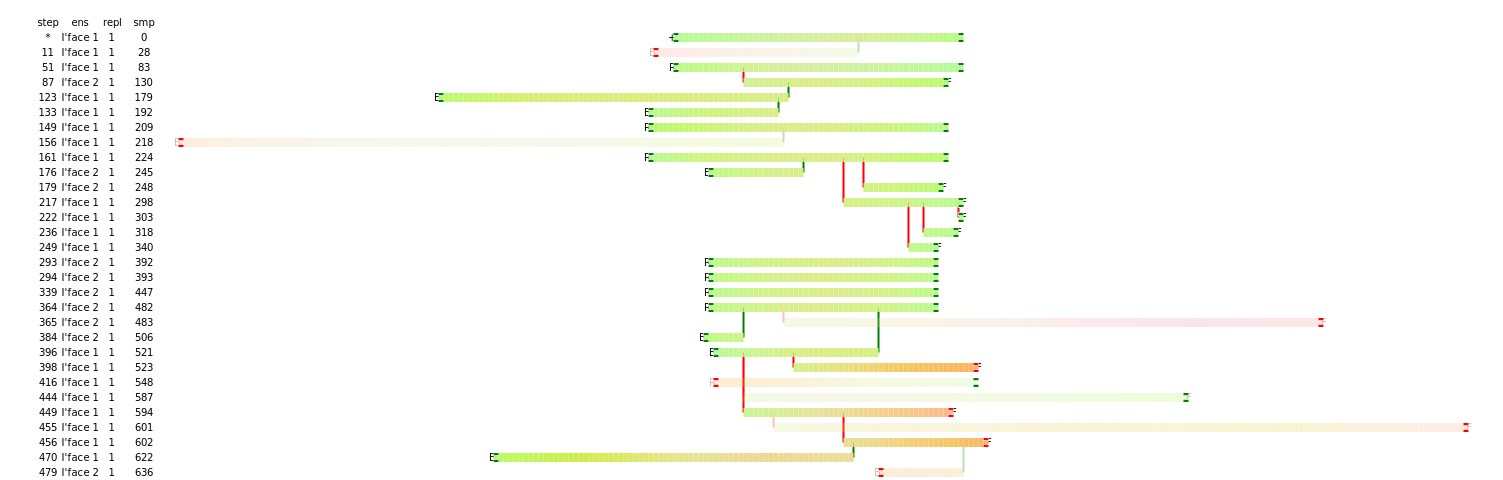

In [26]:
SVG(history.svg())

#### Trajectory Parts

Each trajectory plotted is split into 4 possible parts

###### new
all snapshots that are new. These are usually the forward of backward shooting parts

###### overlap
the part that is in common with the previous one

###### reversed
the part that is in common with the previous one if you would reverse it

###### full
if overlap is actually the full trajectory is is named full


#### Correlation

The SampleList object can check for decorrelation.

In [27]:
decorrelated = history.samples.decorrelated
print "We have " + str(len(decorrelated)) + " decorrelated samples."

We have 4 decorrelated samples.


In [28]:
map(storage.idx, decorrelated)

[0, 179, 521, 622]

Note that this list is not necessarily unique. The function starts with the first one and once it finds a new uncorrelated (no shared snapshots) one it will be added to the list. This idea of decorrelated is of course dependend on the order in which the samples are traversed.

#### Useful options

##### Values on single frame/snapshots

You can add a value to each snapshot

In [29]:
reload(vis)
history = vis.PathTreeBuilder.from_steps(storage.steps[:], 2, True)

# Use the `.idx` function of the storage as values for each snapshot.
history.op = lambda x: str(storage.idx(x))[-2:]

# Adjust the width of each snapshot
history.options.css['scale_x'] = 10

# Set the width to use native pixels and reflect the actual size of the SVG
history.options.css['width'] = '100%'

# Use the default setting and say that all new snapshots should be plotted as single
history.options.movers['default']['new'] = 'single'
history.options.movers['default']['overlap'] = 'block'
history.options.movers['default']['reversed'] = 'block'

# Allow to flip the time direction to better match reversible moves. BEWARE that the direction
# of time has no meaning here. It is exclusivey to study decorrelation of generated paths.
history.samples.flip_time_direction = True

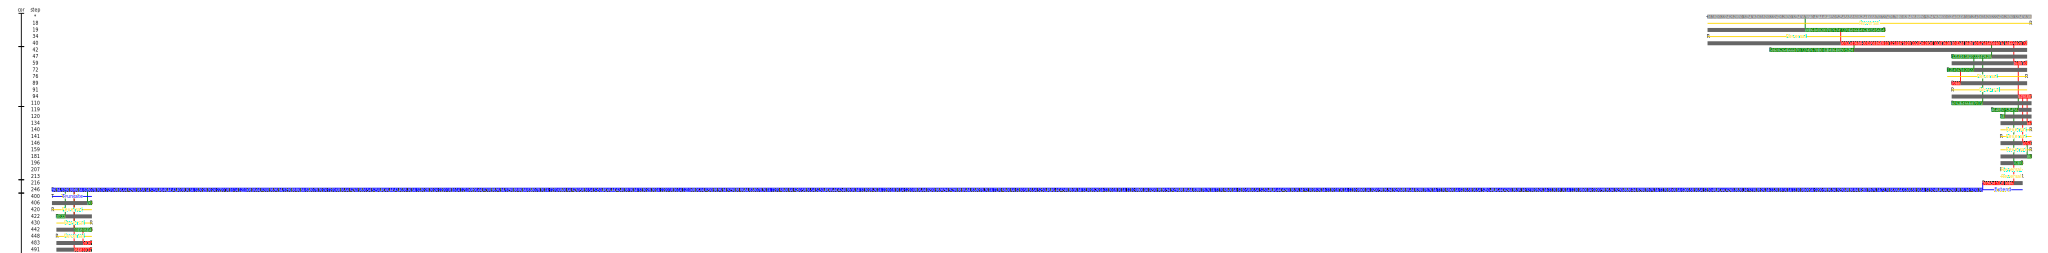

In [30]:
SVG(history.svg())

##### Reset options

Return to the stardard view

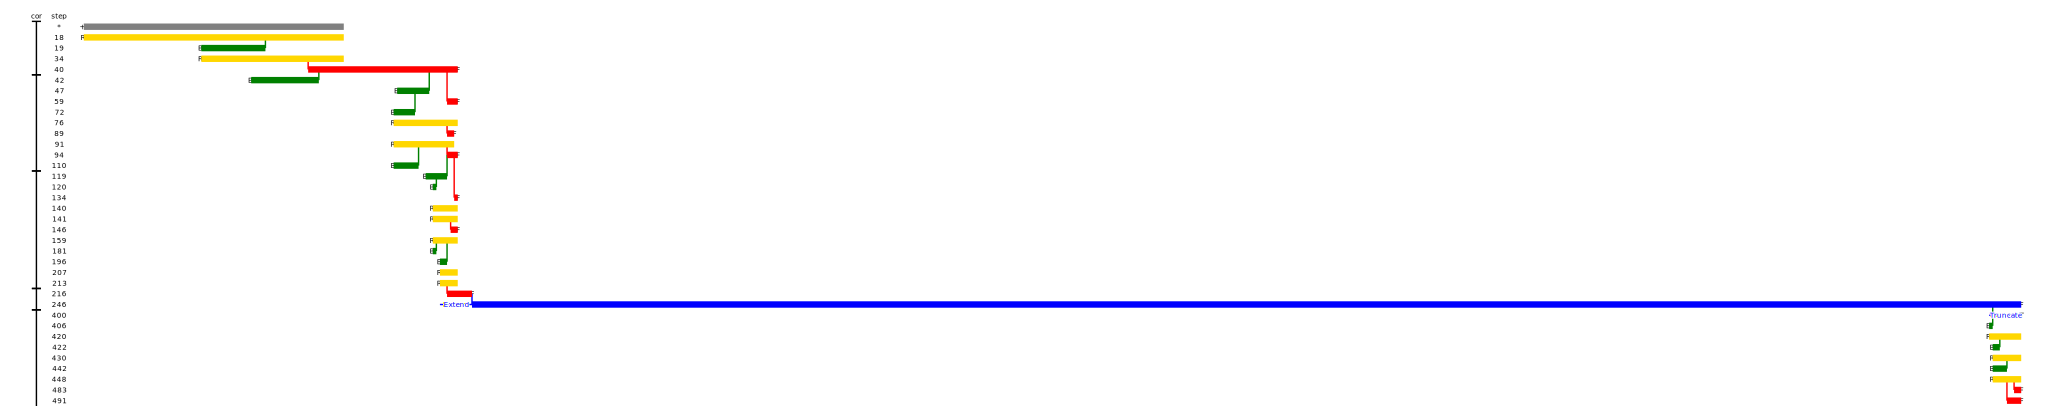

In [31]:
history.reset_options()
history.samples.flip_time_direction = False
SVG(history.svg())